In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
import pandas as pd

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape for CNN
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
def build_cnn(activation="relu", optimizer="adam", use_bn=True, dropout_rate=0.25):

    model = Sequential()

    model.add(Conv2D(32, (3,3), activation=activation, input_shape=(28,28,1)))
    if use_bn:
        model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation=activation))
    if use_bn:
        model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [4]:
def train_model(model, epochs=10):
    history = model.fit(
        x_train_cnn, y_train_cat,
        validation_data=(x_test_cnn, y_test_cat),
        epochs=epochs,
        batch_size=128,
        verbose=0
    )
    return history

TASK 1

In [12]:
activations = ["sigmoid", "tanh", "relu"]
activation_results = {}
histories_activation = {}

for act in activations:
    model = build_cnn(activation=act, optimizer=Adam(), use_bn=False) #with bn=True, all the activations perform similarly
    hist = train_model(model, epochs=10)
    histories_activation[act] = hist
    activation_results[act] = hist.history["val_accuracy"][-1]

activation_results

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'sigmoid': 0.9864000082015991,
 'tanh': 0.9866999983787537,
 'relu': 0.9919000267982483}

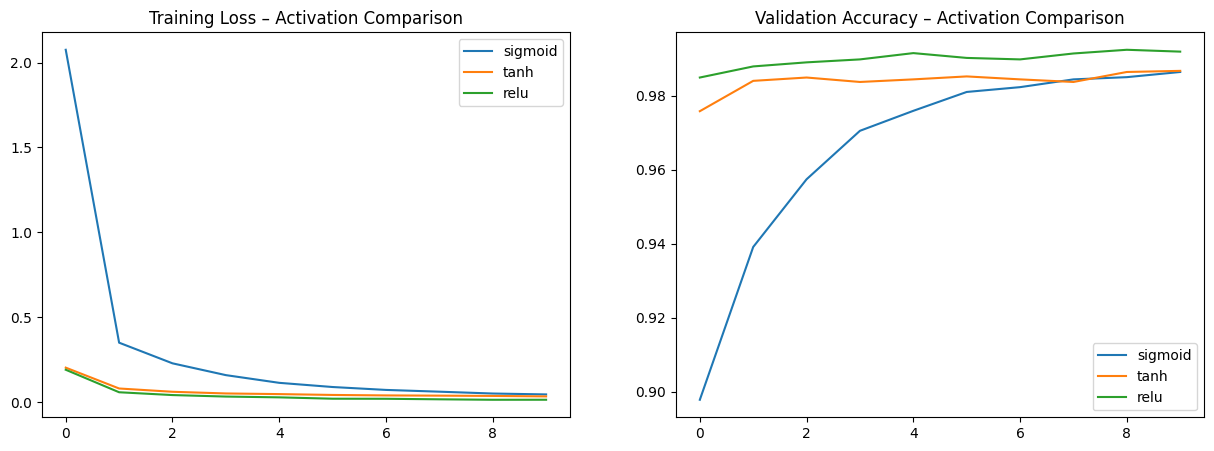

In [13]:
plt.figure(figsize=(15,5))

# LOSS
plt.subplot(1,2,1)
for act in activations:
    plt.plot(histories_activation[act].history["loss"], label=f"{act}")
plt.title("Training Loss – Activation Comparison")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
for act in activations:
    plt.plot(histories_activation[act].history["val_accuracy"], label=f"{act}")
plt.title("Validation Accuracy – Activation Comparison")
plt.legend()

plt.show()

TASK 2

In [7]:
optimizers = {
    "SGD": SGD(learning_rate=0.01),
    "SGD_momentum": SGD(learning_rate=0.01, momentum=0.9),
    "Adam": Adam()
}

optimizer_results = {}
histories_optimizer = {}

for name, opt in optimizers.items():
    model = build_cnn(activation="relu", optimizer=opt, use_bn=True)
    hist = train_model(model, epochs=10)
    histories_optimizer[name] = hist
    optimizer_results[name] = hist.history["val_accuracy"][-1]

optimizer_results


{'SGD': 0.9901000261306763,
 'SGD_momentum': 0.9886999726295471,
 'Adam': 0.9894999861717224}

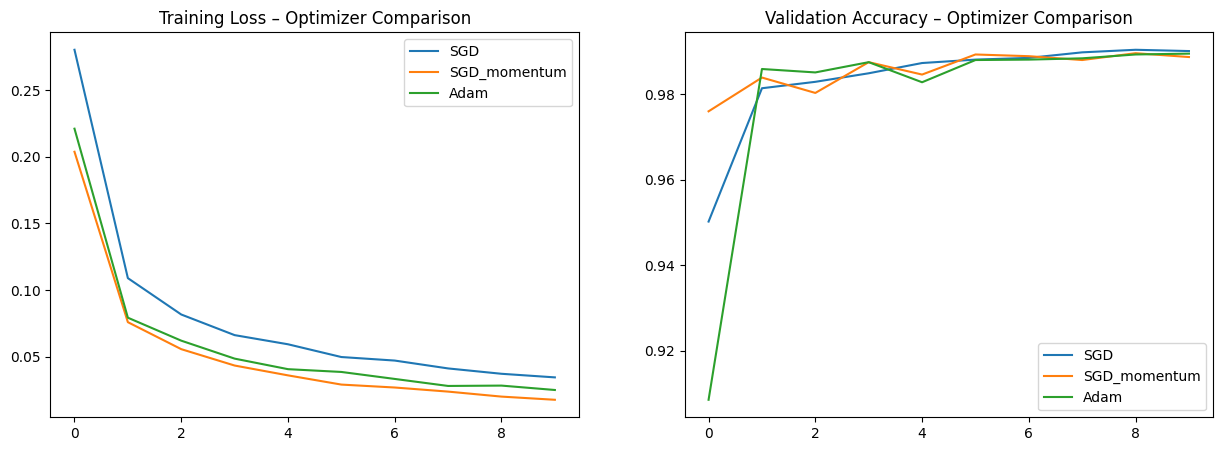

In [8]:
plt.figure(figsize=(15,5))

# LOSS
plt.subplot(1,2,1)
for name in optimizers:
    plt.plot(histories_optimizer[name].history["loss"], label=name)
plt.title("Training Loss – Optimizer Comparison")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
for name in optimizers:
    plt.plot(histories_optimizer[name].history["val_accuracy"], label=name)
plt.title("Validation Accuracy – Optimizer Comparison")
plt.legend()

plt.show()

TASK 3

In [9]:
configurations = {
    "No BN, No Dropout": (False, 0),
    "No BN, Dropout=0.1": (False, 0.1),
    "BN + Dropout=0.25": (True, 0.25),
}

bn_results = {}
histories_bn = {}

for name, (use_bn, do_rate) in configurations.items():
    model = build_cnn(activation="relu", optimizer=Adam(), use_bn=use_bn, dropout_rate=do_rate)
    hist = train_model(model, epochs=10)
    histories_bn[name] = hist
    bn_results[name] = hist.history["val_accuracy"][-1]

bn_results

{'No BN, No Dropout': 0.989799976348877,
 'No BN, Dropout=0.1': 0.9912999868392944,
 'BN + Dropout=0.25': 0.9890000224113464}

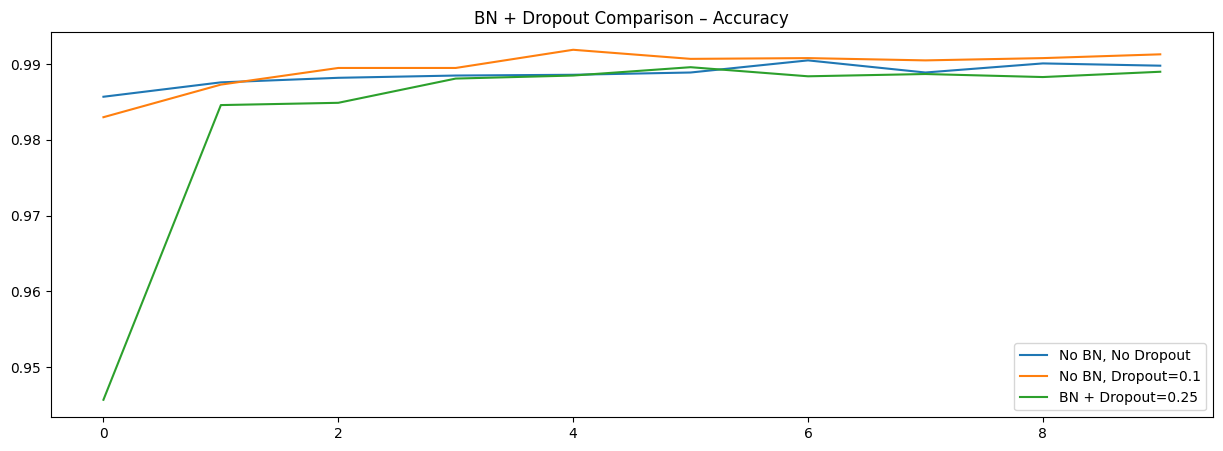

In [10]:
plt.figure(figsize=(15,5))

# VAL ACC
for name in configurations:
    plt.plot(histories_bn[name].history["val_accuracy"], label=name)

plt.title("BN + Dropout Comparison – Accuracy")
plt.legend()
plt.show()

In [14]:
rows = []

# From Task 1
for act in activation_results:
    rows.append(["Activation Test", act, "Adam", 10, activation_results[act]])

# From Task 2
for opt in optimizer_results:
    rows.append(["Optimizer Test", "ReLU", opt, 10, optimizer_results[opt]])

# From Task 3
for cfg in bn_results:
    rows.append(["BN/Dropout Test", "ReLU + Adam", cfg, 10, bn_results[cfg]])

df = pd.DataFrame(rows, columns=["Experiment", "Activation", "Optimizer", "Epochs", "Final Accuracy"])
df

,Experiment,Activation,Optimizer,Epochs,Final Accuracy
0,Activation Test,sigmoid,Adam,10,0.9864
1,Activation Test,tanh,Adam,10,0.9867
2,Activation Test,relu,Adam,10,0.9919
3,Optimizer Test,ReLU,SGD,10,0.9901
4,Optimizer Test,ReLU,SGD_momentum,10,0.9887
5,Optimizer Test,ReLU,Adam,10,0.9895
6,BN/Dropout Test,ReLU + Adam,"No BN, No Dropout",10,0.9898
7,BN/Dropout Test,ReLU + Adam,"No BN, Dropout=0.1",10,0.9913
8,BN/Dropout Test,ReLU + Adam,BN + Dropout=0.25,10,0.9890
